# Deep Learning Model - CNN


In [1]:
# filter out unncessary warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


In [3]:
# remove unnecessary TF logs
import logging
tf.get_logger().setLevel(logging.ERROR)

In [4]:
# check keras and TF version used
print('TF Version:', tf.__version__)
print('Keras Version:', keras.__version__)
print('Number of available GPUs:', len(tf.config.list_physical_devices('GPU')))

TF Version: 2.7.0
Keras Version: 2.7.0
Number of available GPUs: 0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Read the data
df = pd.read_csv('/content/drive/My Drive/ML_NLP/covid_articles_preprocessed.csv')

## Merge Tags

tag_map = {'consumer':'general',
           'healthcare':'science',
           'automotive':'business',
           'environment':'science',
           'construction':'business',
           'ai':'tech'}

df['tags'] = [(lambda tags: tag_map[tags] if tags in tag_map.keys() else tags)(tags)
                          for tags in df['topic_area']]
df.tags.value_counts()

business    245652
general      86372
finance      22386
tech          8915
science       5595
Name: tags, dtype: int64

In [7]:
X = df.content.tolist()
y = df.tags.values

enc = LabelEncoder()
y = enc.fit_transform(y)
enc_tags_mapping = dict(zip(enc.transform(enc.classes_), enc.classes_))

## Split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=21)

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_validation = tokenizer.texts_to_sequences(X_validation)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


In [9]:
maxlen = 470

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_validation = pad_sequences(X_validation, padding='post', maxlen=maxlen)

In [13]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Dropout(rate=0.2, seed=21))
model.add(layers.Conv1D(50, 7, padding="valid", activation="relu", strides=3))
model.add(layers.Conv1D(50, 7, padding="valid", activation="relu", strides=3))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(rate=0.5, seed=21))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 470, 50)           46890800  
                                                                 
 dropout_2 (Dropout)         (None, 470, 50)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 155, 50)           17550     
                                                                 
 conv1d_3 (Conv1D)           (None, 50, 50)            17550     
                                                                 
 global_average_pooling1d_1   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               26112     
                                                      

In [11]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [14]:
checkpoint_path = "/content/drive/My Drive/ML_NLP/training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
my_callbacks = [
                keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=False),
                keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
                ]


history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_validation, y_validation),
                    batch_size=5000,
                    callbacks=[my_callbacks])

model.save('/content/drive/My Drive/ML_NLP/saved_model/my_model-2')

Epoch 1/50
42/42 [==============================] - 227s 5s/step - loss: 1.1017 - accuracy: 0.6496 - val_loss: 0.8524 - val_accuracy: 0.6689
Epoch 2/50
42/42 [==============================] - 223s 5s/step - loss: 0.7952 - accuracy: 0.6709 - val_loss: 0.6760 - val_accuracy: 0.7671
Epoch 3/50
42/42 [==============================] - 231s 5s/step - loss: 0.5495 - accuracy: 0.8062 - val_loss: 0.4772 - val_accuracy: 0.8255
Epoch 4/50
42/42 [==============================] - 225s 5s/step - loss: 0.4093 - accuracy: 0.8481 - val_loss: 0.4187 - val_accuracy: 0.8427
Epoch 5/50
42/42 [==============================] - 224s 5s/step - loss: 0.3199 - accuracy: 0.8815 - val_loss: 0.3945 - val_accuracy: 0.8608
Epoch 6/50
42/42 [==============================] - 232s 6s/step - loss: 0.2410 - accuracy: 0.9124 - val_loss: 0.3887 - val_accuracy: 0.8717
Epoch 7/50
42/42 [==============================] - 226s 5s/step - loss: 0.1774 - accuracy: 0.9358 - val_loss: 0.4063 - val_accuracy: 0.8750
Epoch 8/50
42

Training Accuracy: 0.9810
Validation Accuracy:  0.8757


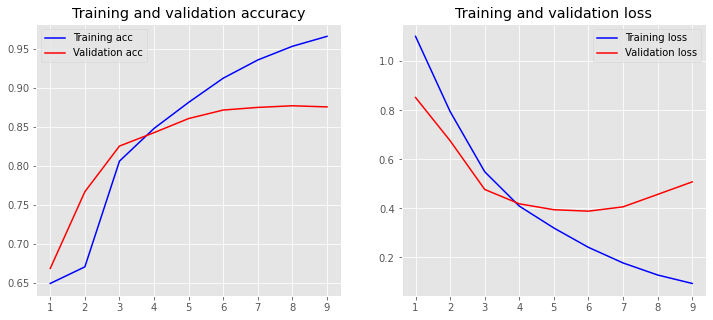

In [15]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_validation, y_validation, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [16]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
print(classification_report(y_test, y_pred, target_names=list(enc_tags_mapping.values())))

              precision    recall  f1-score   support

    business       0.92      0.94      0.93     73935
     finance       0.62      0.72      0.67      6788
     general       0.87      0.84      0.86     25646
     science       0.35      0.09      0.14      1690
        tech       0.41      0.38      0.40      2617

    accuracy                           0.88    110676
   macro avg       0.63      0.59      0.60    110676
weighted avg       0.87      0.88      0.87    110676

